In this notebook we will explore OSMnx, a Python package built to use OpenStreetMap.  

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining a Section of Whitby/Oshawa

Here we use longitude and latitude to define a box that represents a portion of the Whitby and Oshawa area.  Later in the project we will define the full area we will be focusing on and will build a comprehensive map and database.  For now we will work with this small section to test functionality. 

In [3]:
###OSHAWA/WHITBY 
north = 43.921848
west = -78.927914
south = 43.885298
east = -78.879737

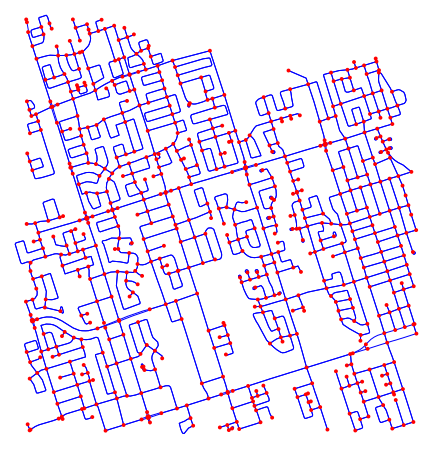

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive') 
# Plotting the map graph 
ox.plot_graph(G, bgcolor='white', edge_color='blue', node_color='red')

In [5]:
# Check the number of nodes in this graph
num_nodes = len(G.nodes)
num_nodes

702

#### Examining a Node 

In [6]:
G[82815119]

AdjacencyView({1136740771: {0: {'osmid': 467766865, 'oneway': True, 'lanes': '3', 'name': 'Bond Street West', 'highway': 'secondary', 'maxspeed': '50', 'length': 216.535, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000017FF2093EE0>}}, 278026371: {0: {'osmid': 467766866, 'lanes': '4', 'ref': '53', 'name': 'Stevenson Road North', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'length': 98.20599999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000017FEBDE2160>}}, 2869399820: {0: {'osmid': 486246944, 'lanes': '4', 'ref': '53', 'name': 'Stevenson Road North', 'highway': 'secondary', 'maxspeed': '50', 'oneway': False, 'length': 179.848, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000017FF20B9F10>}}})

We see that we have a lot of information about each nodes:
- attached nodes 
- street names, number of lanes, speed 
- lenght of road segments connect nodes 

In [7]:
# Print the nodes that are attached by road to this node
for x in G[82815119]:
    print (x)

1136740771
278026371
2869399820


In [9]:
# For two nodes, see the info about the road segment that attaches them
G[82815119][1136740771][0] 

{'osmid': 467766865,
 'oneway': True,
 'lanes': '3',
 'name': 'Bond Street West',
 'highway': 'secondary',
 'maxspeed': '50',
 'length': 216.535,
 'geometry': <shapely.geometry.linestring.LineString at 0x17ff2093ee0>}

### Generating Shortest Path for Each Pair of Nodes

NetworkX has multiple built in shortest path algorithms - including ones built on the A* and Dijkstra search algorithms.  These can be customized to include edge weights - we can explore using this functionality to do things like avoid low speed roads when traffic will be light, or avoid main roads during rush hour.

(Documentation:  https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html)

In [10]:
# For now we will generate the shortest path between each pair of nodes in our graph
all_paths = nx.shortest_path(G)

We have now a list of nodes that represent the shortest path between each pair of nodes in our graph.  What we want to do now is use the stored information in the graph to calculate the lenghts of each of these paths in actual metres of road lenght.  We will build a dataframe where for each node in the graph, its row/column entry will be the shortest path distance to the correspending node in the columns.

### Generating the Distance Between Each Pair of Nodes

In [12]:
# First, generate a list of all the nodes in our graph
nodes_list = list(G.nodes)

In [13]:
# Next, create an empty dataframe with rows and columsn representing each of the nodes
distances = pd.DataFrame(0, index=nodes_list, columns=nodes_list)
distances

,699620,702725,702783,702786,702792,702793,702796,702798,702840,702841,...,4460514911,4460514915,4558860396,4558860398,4558860399,4558860402,6470196804,6470196808,7670957238,8191443811
699620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
702725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
702783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
702786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
702792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4558860402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6470196804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6470196808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7670957238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def len_of_path(path):
    """
    For each list of nodes in a given path, sum the lenghts of the road segments that 
    connect each node from start to finish.
    """
    # Count the number of nodes in the path 
    num_steps = len(path)
    i = 0
    j = 1
    # Start with a default path length of 0
    path_len = 0
    # We want the lenght of any node to itself to be 0
    if num_steps == 1:
        pass
    # Otherwise, for each path step, get the length of the road segment 
    # Total these for each step 
    else:
        while j < num_steps:
            path_len += G[path[i]][path[j]][0]['length']
            i+= 1
            j+=1
    return path_len

We now use this function to fill our data frame with the shortest distance between each pair of nodes.

In [15]:
for x in nodes_list:
    for y in nodes_list:
        try:
            distances.loc[x][y] = len_of_path(all_paths[x][y])
        # in case one node cannot be reached from some other node
        except KeyError:
            pass

In [16]:
distances

,699620,702725,702783,702786,702792,702793,702796,702798,702840,702841,...,4460514911,4460514915,4558860396,4558860398,4558860399,4558860402,6470196804,6470196808,7670957238,8191443811
699620,0,212,445,730,1324,1230,1164,982,1405,1429,...,3780,3776,2784,2731,2765,2823,4375,4213,4284,3537
702725,225,0,233,355,1111,1018,951,770,1193,1216,...,3567,3563,2985,2931,2966,3024,4575,4413,4485,3325
702783,515,233,0,222,1345,1251,1184,1003,1426,1450,...,3800,3796,3218,3165,3199,3257,4808,4646,4718,3558
702786,730,355,222,0,1467,1374,1307,1126,1549,1572,...,3923,3919,3341,3287,3321,3380,4931,4769,4841,3681
702792,1337,1111,1345,1467,0,93,448,341,81,104,...,3468,3464,4097,4043,4077,4136,5687,5525,5597,3226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4558860402,2776,2988,3221,3506,4100,4006,3940,3759,4181,4205,...,4544,4540,136,82,69,0,3536,3374,3446,6314
6470196804,4351,4564,4797,5082,5676,5582,5515,5334,5757,5781,...,4645,5403,3496,3442,3476,3535,0,161,90,7181
6470196808,4189,4402,4635,4920,5514,5420,5353,5172,5595,5619,...,4483,5241,3334,3280,3314,3373,161,0,71,7019
7670957238,4261,4473,4707,4992,5585,5492,5425,5244,5667,5690,...,4554,5312,3406,3352,3386,3444,90,71,0,7091
